# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

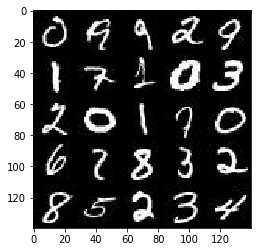

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

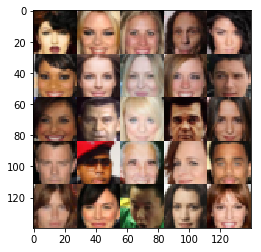

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    # real images placeholder
    real_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    # generator input placeholder
    z = tf.placeholder(tf.float32, (None, z_dim))
    # learning rate placeholder
    learning_rate = tf.placeholder(tf.float32)

    return real_images, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [49]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # leaky ReLU param
        alpha = 0.1
        
        # hidden layer number of channels parameter
        n = 64 
        
        # convolution patch sizes
        s = 5
     
        # first convolutional layer - 14 x 14 x n
        conv1 = tf.layers.conv2d(images, n, s, strides=2, padding='same')
        # batch normalization
        conv1n = conv1 # just as in the DCGAN lesson, we do not normalize the first convolutional layer here
        # leaky ReLU
        conv1r = tf.maximum(alpha * conv1n, conv1n)
        
        # second convolutional layer - 7 x 7 x 2n
        conv2 = tf.layers.conv2d(conv1r, 2 * n, s, strides=2, padding='same')
        # batch normalization
        conv2n = tf.layers.batch_normalization(conv2, training=True)
        # leaky ReLU
        conv2r = tf.maximum(alpha * conv2n, conv2n)
        
        # third convolutional layer - 4 x 4 x 4n
        conv3 = tf.layers.conv2d(conv2r, 4 * n, s, strides=2, padding='same')
        # batch normalization
        conv3n = tf.layers.batch_normalization(conv3, training=True)
        # leaky ReLU
        conv3r = tf.maximum(alpha * conv3n, conv3n)
        
        # fourth convolutional layer - 2 x 2 x 8n
        conv4 = tf.layers.conv2d(conv3r, 8 * n, s, strides=2, padding='same')
        # batch normalization
        conv4n = tf.layers.batch_normalization(conv4, training=True)
        # leaky ReLU
        conv4r = tf.maximum(alpha * conv4n, conv4n)
                
        # reshape for the final layer
        rshp = tf.reshape(conv4r,(-1, 8 * n * 2 * 2))
        # final logits
        logits = tf.layers.dense(rshp, 1)
        # final output
        out = tf.sigmoid(logits)
     

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [50]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse= not is_train):
        
        # leaky ReLU param
        alpha = 0.1
        
        # hidden layer number of channels parameter
        n = 32
        
        # transpose convolution patch sizes (save for the first)
        s = 5
        
        # dense layer on top of z
        d = tf.layers.dense(z, 16 * n * 3 * 3)
        # reshaped dense layer to plug into inverse convolutions
        dr = tf.reshape(d, (-1, 3, 3, 16 * n))
        # batch normalization
        drn = tf.layers.batch_normalization(dr, training=is_train)
        # leaky ReLU
        drnr = tf.maximum(alpha * drn, drn)
        
        # first transpose convolution - 7 x 7 x 4n
        c1 = tf.layers.conv2d_transpose(drnr, 8 * n, 3, strides=2, padding='valid')
        # batch normalization
        c1n = tf.layers.batch_normalization(c1, training=is_train)
        # leaky ReLU
        c1nr = tf.maximum(alpha * c1n, c1n)
        
        # second transpose convolution - 14 x 14 x 2n 
        c2 = tf.layers.conv2d_transpose(c1nr, 4 * n, s, strides=2, padding='same')
        # batch normalization
        c2n = tf.layers.batch_normalization(c2, training=is_train)
        # leaky ReLU
        c2nr = tf.maximum(alpha * c2n, c2n)
        
        # third transpose convolution - 28 x 28 x n 
        c3 = tf.layers.conv2d_transpose(c2nr, 2 * n, s, strides=2, padding='same')
        # batch normalization
        c3n = tf.layers.batch_normalization(c3, training=is_train)
        # leaky ReLU
        c3nr = tf.maximum(alpha * c3n, c3n)
        
        # fourth transpose convolution - 28 x 28 x out_channel_dim
        c4 = tf.layers.conv2d_transpose(c3nr, out_channel_dim, s, strides=1, padding='same')
        
        # final output
        out = tf.tanh(c4)        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [51]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # discriminator outputs for real images    
    real_d_out, real_d_logits = discriminator(input_real)
    # fake images from z
    fake_images = generator(input_z, out_channel_dim)
    # discriminator outputs for fake images
    fake_d_out, fake_d_logits = discriminator(fake_images, reuse=True)
    
    # real image discriminator loss
    real_d_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=real_d_logits, labels=tf.ones_like(real_d_out) * 0.9))
    # fake image discriminator loss
    fake_d_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_d_logits, labels=tf.zeros_like(fake_d_out)))
    
    # total discriminator loss
    d_loss = real_d_loss + fake_d_loss
    # generator loss
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_d_logits, labels=tf.ones_like(fake_d_out)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [52]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get trainable variables list
    t_vars = tf.trainable_variables()
    # Get trainable discriminator variables
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    # Get trainable generator variables
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Generator update operations
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    # Optimizers
    with tf.control_dependencies(gen_updates):
        # Discriminator train optimizer
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        # Generator train optimizer
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [53]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [54]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # number of color channels
    _, image_width, image_height, n_channels = data_shape
    
    # model input placeholders
    img, z, lr = model_inputs(image_width, image_height, n_channels, z_dim)
    
    # generator and discriminator losses
    d_loss, g_loss = model_loss(img, z, n_channels)
    
    # generator and discriminator optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            # Set step count to zero
            steps = 0
            
            # Set sums of losses to zero
            dloss_sum = 0
            gloss_sum = 0
            
            # Set batch counter for average losses to zero
            batch_count = 0
            
            for batch_images in get_batches(batch_size):
                
                # Increase step count
                steps += 1
                
                # Rescale image batch to [-1,1]
                batch_images *= 2
                
                # Random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run discriminator optimizer
                _ = sess.run(d_opt, feed_dict={img: batch_images, z: batch_z, lr: learning_rate})
                
                # Run generator optimizer
                _ = sess.run(g_opt, feed_dict={z: batch_z, lr: learning_rate})
                
                # Update loss sums
                dloss_sum += d_loss.eval({z: batch_z, img: batch_images})
                gloss_sum += g_loss.eval({z: batch_z})
                
                # Increase batch count for average loss calculations
                batch_count += 1
                
                # Print the losses every 100 batches
                if steps % 100 == 0:
                    
                    # Show generator output
                    show_generator_output(sess, 16, z, n_channels, data_image_mode)
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Avg. Discriminator Loss: {:.4f}...".format(dloss_sum / batch_count),
                          "Avg. Generator Loss: {:.4f}".format(gloss_sum / batch_count))                
                    
                    # Set loss sums to zero
                    dloss_sum = 0
                    gloss_sum = 0
                    
                    # Set batch count for average loss calculation to zero
                    batch_count = 0
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

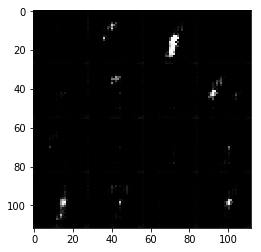

Epoch 1/2... Avg. Discriminator Loss: 1.3200... Avg. Generator Loss: 3.1254


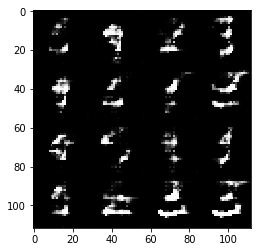

Epoch 1/2... Avg. Discriminator Loss: 1.1161... Avg. Generator Loss: 1.5115


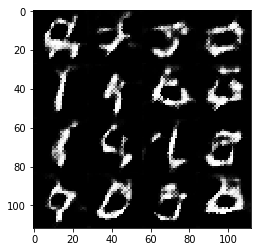

Epoch 1/2... Avg. Discriminator Loss: 1.2843... Avg. Generator Loss: 1.1418


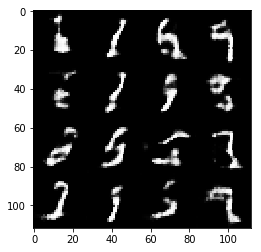

Epoch 1/2... Avg. Discriminator Loss: 1.1647... Avg. Generator Loss: 1.0666


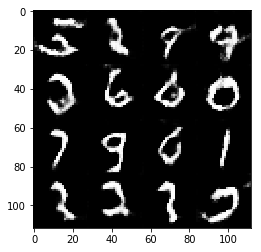

Epoch 1/2... Avg. Discriminator Loss: 1.1930... Avg. Generator Loss: 1.0469


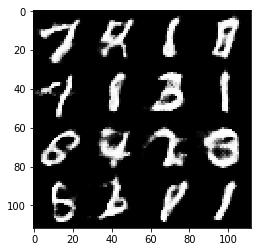

Epoch 1/2... Avg. Discriminator Loss: 1.2058... Avg. Generator Loss: 1.0578


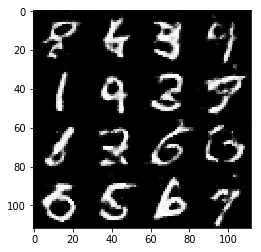

Epoch 1/2... Avg. Discriminator Loss: 1.2307... Avg. Generator Loss: 0.9264


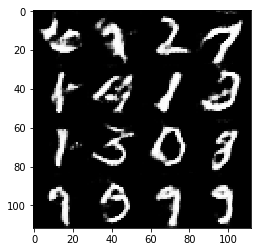

Epoch 1/2... Avg. Discriminator Loss: 1.2599... Avg. Generator Loss: 0.9222


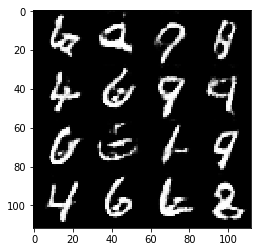

Epoch 1/2... Avg. Discriminator Loss: 1.2893... Avg. Generator Loss: 0.8912


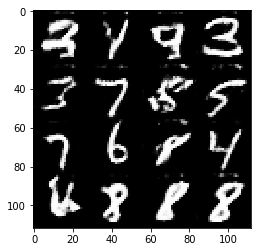

Epoch 2/2... Avg. Discriminator Loss: 1.3644... Avg. Generator Loss: 0.8344


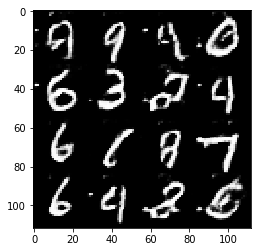

Epoch 2/2... Avg. Discriminator Loss: 1.2966... Avg. Generator Loss: 0.8596


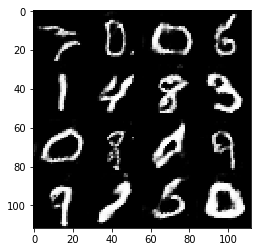

Epoch 2/2... Avg. Discriminator Loss: 1.3376... Avg. Generator Loss: 0.8505


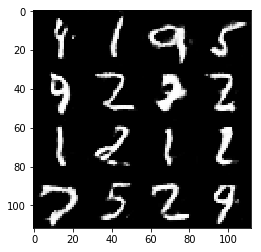

Epoch 2/2... Avg. Discriminator Loss: 1.3590... Avg. Generator Loss: 0.8202


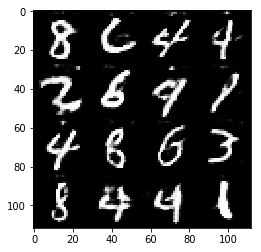

Epoch 2/2... Avg. Discriminator Loss: 1.3665... Avg. Generator Loss: 0.7862


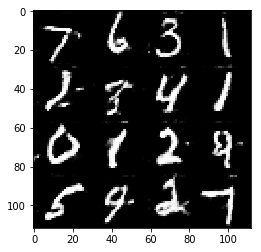

Epoch 2/2... Avg. Discriminator Loss: 1.3730... Avg. Generator Loss: 0.8153


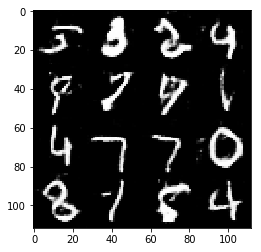

Epoch 2/2... Avg. Discriminator Loss: 1.4156... Avg. Generator Loss: 0.8022


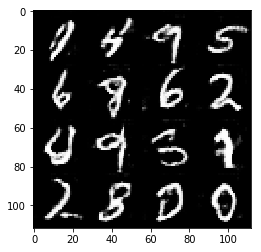

Epoch 2/2... Avg. Discriminator Loss: 1.3963... Avg. Generator Loss: 0.8376


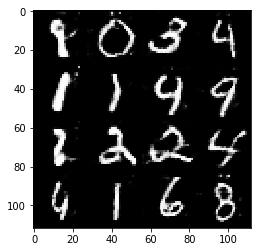

Epoch 2/2... Avg. Discriminator Loss: 1.3646... Avg. Generator Loss: 0.8002


In [55]:
batch_size = 64
z_dim = 100
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

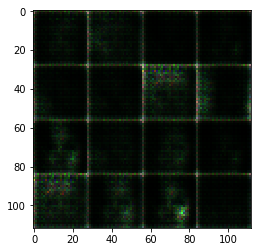

Epoch 1/1... Avg. Discriminator Loss: 1.0635... Avg. Generator Loss: 2.7702


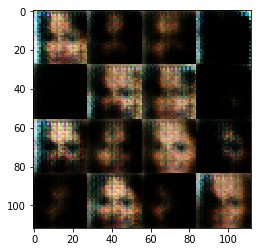

Epoch 1/1... Avg. Discriminator Loss: 1.1134... Avg. Generator Loss: 1.6996


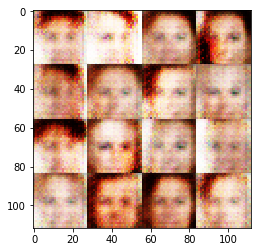

Epoch 1/1... Avg. Discriminator Loss: 1.0962... Avg. Generator Loss: 1.4507


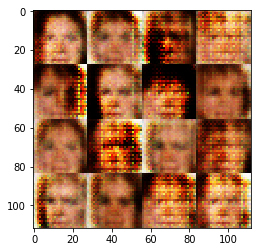

Epoch 1/1... Avg. Discriminator Loss: 0.9623... Avg. Generator Loss: 1.8516


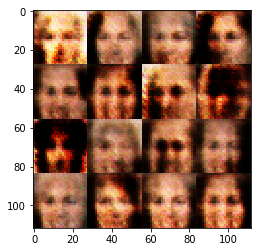

Epoch 1/1... Avg. Discriminator Loss: 1.0210... Avg. Generator Loss: 1.6983


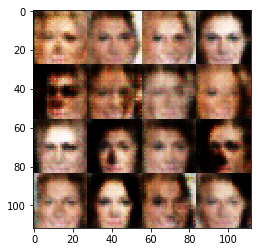

Epoch 1/1... Avg. Discriminator Loss: 1.0348... Avg. Generator Loss: 1.4366


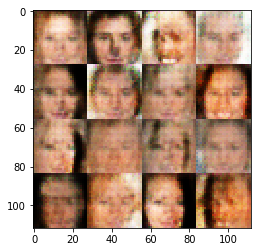

Epoch 1/1... Avg. Discriminator Loss: 1.0731... Avg. Generator Loss: 1.5948


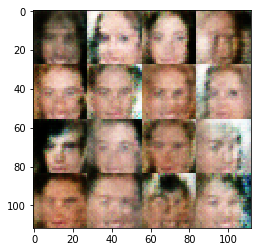

Epoch 1/1... Avg. Discriminator Loss: 1.0197... Avg. Generator Loss: 1.4129


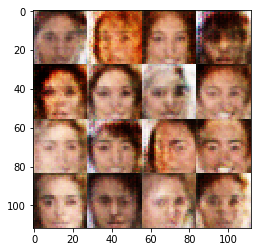

Epoch 1/1... Avg. Discriminator Loss: 1.0231... Avg. Generator Loss: 1.5070


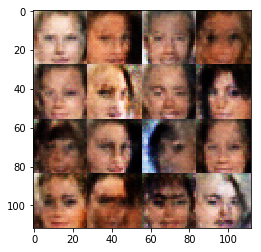

Epoch 1/1... Avg. Discriminator Loss: 1.0210... Avg. Generator Loss: 1.3433


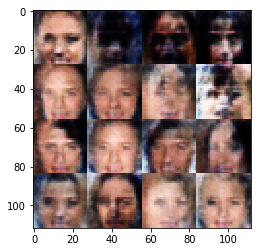

Epoch 1/1... Avg. Discriminator Loss: 1.0068... Avg. Generator Loss: 1.3179


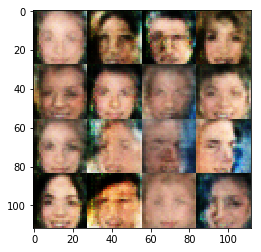

Epoch 1/1... Avg. Discriminator Loss: 1.0493... Avg. Generator Loss: 1.3062


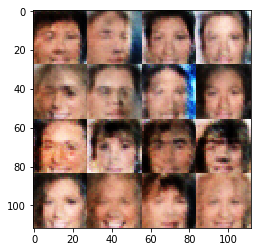

Epoch 1/1... Avg. Discriminator Loss: 1.0067... Avg. Generator Loss: 1.2889


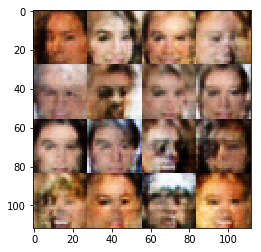

Epoch 1/1... Avg. Discriminator Loss: 1.0505... Avg. Generator Loss: 1.2895


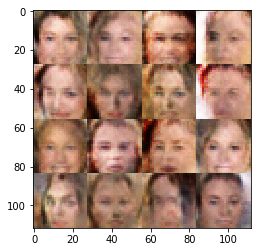

Epoch 1/1... Avg. Discriminator Loss: 1.0298... Avg. Generator Loss: 1.2875


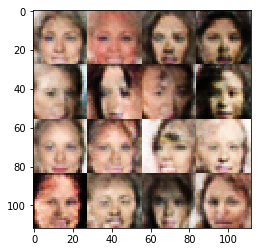

Epoch 1/1... Avg. Discriminator Loss: 1.0713... Avg. Generator Loss: 1.1986


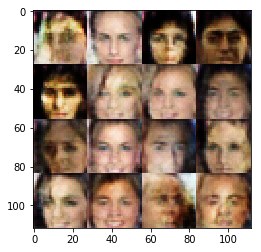

Epoch 1/1... Avg. Discriminator Loss: 1.0601... Avg. Generator Loss: 1.1711


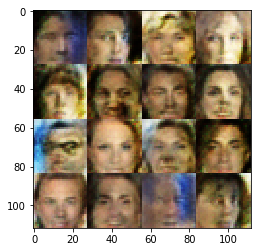

Epoch 1/1... Avg. Discriminator Loss: 1.0561... Avg. Generator Loss: 1.1870


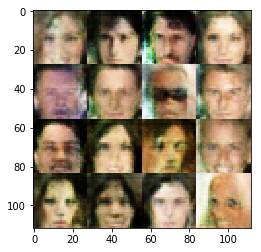

Epoch 1/1... Avg. Discriminator Loss: 1.0640... Avg. Generator Loss: 1.1653


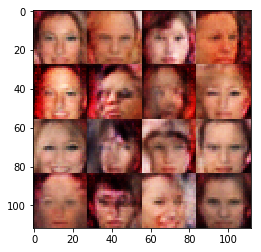

Epoch 1/1... Avg. Discriminator Loss: 1.1200... Avg. Generator Loss: 1.1624


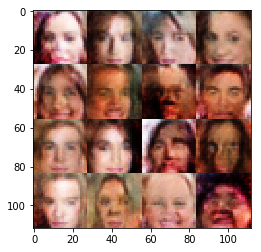

Epoch 1/1... Avg. Discriminator Loss: 1.0884... Avg. Generator Loss: 1.0987


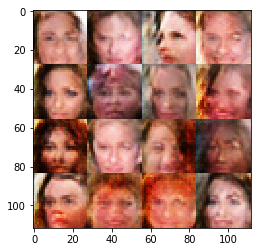

Epoch 1/1... Avg. Discriminator Loss: 1.0492... Avg. Generator Loss: 1.1566


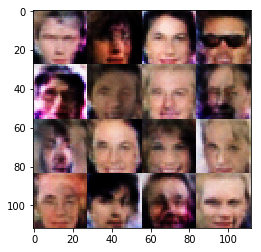

Epoch 1/1... Avg. Discriminator Loss: 1.0755... Avg. Generator Loss: 1.0935


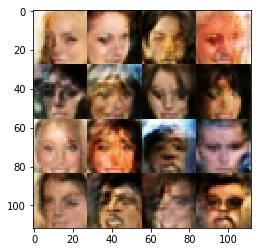

Epoch 1/1... Avg. Discriminator Loss: 1.1035... Avg. Generator Loss: 1.0902


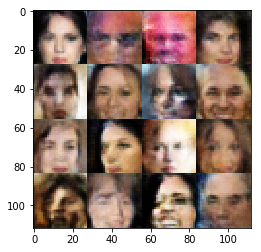

Epoch 1/1... Avg. Discriminator Loss: 1.0824... Avg. Generator Loss: 1.1016


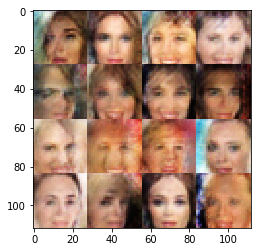

Epoch 1/1... Avg. Discriminator Loss: 1.0970... Avg. Generator Loss: 1.1082


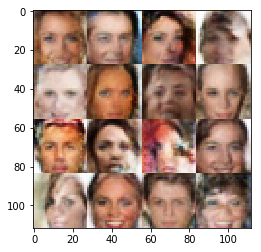

Epoch 1/1... Avg. Discriminator Loss: 1.0822... Avg. Generator Loss: 1.0910


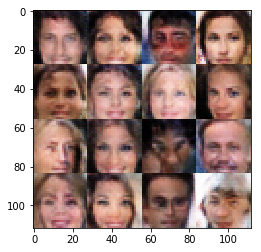

Epoch 1/1... Avg. Discriminator Loss: 1.0855... Avg. Generator Loss: 1.0711


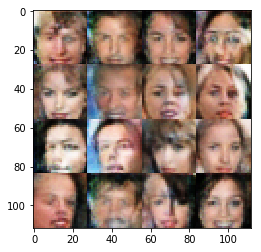

Epoch 1/1... Avg. Discriminator Loss: 1.0892... Avg. Generator Loss: 1.0596


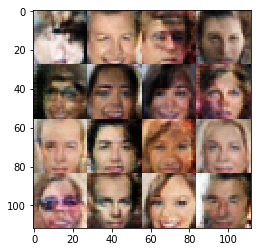

Epoch 1/1... Avg. Discriminator Loss: 1.0947... Avg. Generator Loss: 1.0502


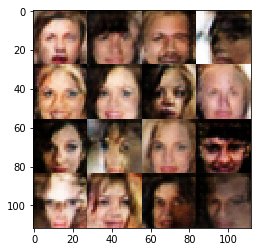

Epoch 1/1... Avg. Discriminator Loss: 1.1157... Avg. Generator Loss: 1.0404


In [58]:
batch_size = 64
z_dim = 128 # higher dimensionality here - may help to learn diverse faces
learning_rate = 0.0003  # lower learning rate here - significantly higher values seemed to blow up 
                        # the generator/discriminator system, though I did not watch until the end 
                        # of the training process for every setting of the learning rate I tried
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.